# Atomic Simulation Environment

An atomic configuration is defined by 

- The Cartesian positions of atoms
- The atomic species 
- A simulation cell (possibly with periodic boundary conditions)

So we could define a hydrogen molecule like so

In [1]:
positions = [[4.5, 5, 5], [5.5, 5, 5]]
numbers = [1, 1]
cell = [[10, 0, 0], [0, 10.0, 0], [0, 0, 10.0]] # 3x3 matrix, each row is a cell vector.

This is however quite clumsy, there's nothing in the code that keeps this three 
variables together so we would need to always make to use the correct three 
together. 

We could put them in a tuple, 

In [2]:
molecule = (positions, numbers, cell)

Which is already an improvement, however we may leverage object-oriented spirit of Python 
and define a custom class that contains these variables.
Luckily, others have done this for us and this is, part of, what the `ase` package provides.

In [3]:
from ase import Atoms

molecule = Atoms(positions=[[4.5, 5, 5], [5.5, 5, 5]], 
                 numbers=[1, 1],
                #  symbols='H2' # Alternative to numbers
                 cell=[10, 10, 10], # ASE assumes a cubic cell when just given a list of 3 numbers. 
                 pbc=[False, False, False]) # The cell is not periodic in any direction. pbc = Periodic Boundary Conditions

This also allows us to benefit from other utility of `ase`

In [15]:
from ase.visualize import view

view(molecule, viewer='x3d')

### Exercise: Water molecule

Use `ase` to define a water molecule. 

Hint: You can look up the oxygen-hydrogen bond length and the angle between the hydrogens [online](https://en.wikipedia.org/wiki/Water#/media/File:H2O_2D_labelled.svg) and use 
those to determine the positions of the three atoms. 

You may choose the computational cell yourself.

In [ ]:
# Your code here

### Exercise: Two water molecules

Use the water molecule you defined before to make a cell containing two 
water molecules. 

You can use 
```
atoms_combined = atoms_1 + atoms_2 
```
Where `atoms_1` and `atoms_2` are instances of `Atoms` objects. 

In [ ]:
# Your code here

### Exercise: Crystalline silver

![Depiction of the fcc crystal structure of silver](https://www.e-education.psu.edu/matse81/sites/www.e-education.psu.edu.matse81/files/images/lesson05/FCC.png)

In material science a crystal is a material that is periodic in every direction, 
that is it consists of a infinitely repeating unit cell. 

Silver has the face-centred cubic crystal structure where each side of the unit cell 
has length of a, also known as the lattice constant. 

The cell contains four silver atoms 
- 1/8 of an atom placed at every corner
- Half an atom placed in the middle of each of the faces. 

Because of periodic boundary conditions half an atom in each face corresponds, to one atom in half the faces. 
An eigth of an atom at every corner is equivalent to one atom at the origin. 

Write a *function* `get_fcc_silver(a)` that takes the lattice constant as an input and returns an `Atoms`
object for fcc silver with that lattice constant. 

In [5]:
def get_fcc_silver(a):
    crystal = Atoms(
        symbols='Ag4',
        positions=[[0, 0, 0], 
                   [a/2, a/2, 0],
                   [a/2, 0, a/2],
                   [0, a/2, a/2]],
        cell = [a, a, a],
        pbc=[True, True, True]
    )
    return crystal

Another important part of `ase` is that it interfaces to many methods for calculating 
the total energy of an `Atoms`-object, such as 

- **Density Functional Theory**: GPAW, VASP, QuantumEspresso, Abinit, etc..
- **Empirical potentials**: Lennard Jones, Effective Medium Theory, ..

These are all approximations for solving the many electron time-independent Schrodinger equation. 
An energy calculation can be performed, like so

In [6]:
from ase.calculators.emt import EMT

# Define the calculator.
# The one used here is Effective Medium Theory, which is a relatively 
# simple empirical potential so it doesn't require any additional settings.
calculator = EMT() 

# Get the atoms object
atoms = get_fcc_silver(4.0)

# Attach the calculator to the atoms object
atoms.calc = calculator

# Perform the calculation
energy = atoms.get_potential_energy()
print(energy)

0.04747945905394424


Use your function `get_fcc_silver` to calculate the total energy for 
several lattice constants and make a plot of the total energy as a 
function of the lattice constant.

If everything goes well you should get a parabolic curve where the minimum value 
is in good agreement with e.g. wikipedia. 

In [7]:
import numpy as np
lattice_constants = np.linspace(3.8, 4.2, 50)

energies = np.zeros_like(lattice_constants)

for i, a in enumerate(lattice_constants):
    atoms = get_fcc_silver(a)
    atoms.calc = EMT()
    energies[i] = atoms.get_potential_energy()

The cell below plots the energy as a function of the lattice constant.

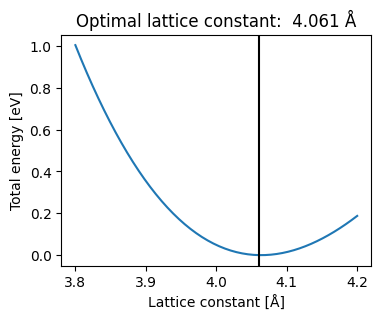

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(lattice_constants, energies)
optimal = lattice_constants[np.argmin(energies)]
ax.axvline(optimal, color='black')

ax.set_xlabel('Lattice constant [Å]')
ax.set_ylabel('Total energy [eV]')
ax.set_title(f'Optimal lattice constant: {optimal: 0.3f} Å')
plt.show()

### Exercise: Oxygen adsorption on Ag(100)

We can also model surfaces, this is done by having periodic boundary conditions in 
two dimensions and adding vacuum in the third. 

`ase` provides utility functions to construct such configurations.

In [9]:
from ase.build import fcc100

surface = fcc100(symbol='Ag', 
                 size=(5, 5, 3), # Repeat the unit cell 5 times in x and y, and 3 times in z.
                 vacuum=10.0, 
                 a=4.06) # Add 10 Å of vacuum in the z-direction.

view(surface, viewer='x3d')

<Popen: returncode: None args: ['/Users/au616397/Repositories/imlms/.venv/bi...>

This surface has three unique adsorption sites

- Top sites: Directly above a silver atom in the top layer.
- Bridge sites: In the middle between two silver atoms in the top layer.
- Hollow site: In the center of four silver atoms in the top layer.

Write three functions that create the surface with an oxygen atom in each of these 
three configurations given a z-coordinate, that is 

- `get_top_site(z)`
- `get_bridge_site(z)`
- `get_hollow_site(z)`

Hint: You can find the $x$ and $y$ coordinates for each site as average over the $x$ or $y$ coordinates 
of selected atoms from the surface. To find the indices of atoms to average over, use the viewer/gui.
For example; 

`bridge_site_x = (surface.positions[62, 0] + surface.positions[67, 0]) / 2`

Hint: Create an `Atoms` object for the surface and the oxygen separately and add them together 
like you did for the molecules.

In [10]:
def get_surface():
    surface = fcc100(symbol='Ag', 
                 size=(5, 5, 3), # Repeat the unit cell 5 times in x and y, and 3 times in z.
                 vacuum=10.0, 
                 a=4.06) # Add 10 Å of vacuum in the z-direction.
    return surface


def get_top_site(z):
    """
    Indices on 5x5x3: 62
    """
    surface = get_surface()
    x = surface.positions[62, 0]
    y = surface.positions[62, 1]
    adsorbant = Atoms('O', positions=[[x, y, z]])
    return surface + adsorbant

def get_bridge_site(z):
    """
    Indices on 5x5x3: 62, 67
    """
    surface = get_surface()
    indices = [62, 67]
    x = surface.positions[indices, 0].mean()
    y = surface.positions[indices, 1].mean()
    adsorbant = Atoms('O', positions=[[x, y, z]])
    return surface + adsorbant

def get_hollow_site(z):
    """
    Indices on 5x5x3: 62, 67
    """
    surface = get_surface()
    indices = [62, 67, 63, 68]
    x = surface.positions[indices, 0].mean()
    y = surface.positions[indices, 1].mean()
    adsorbant = Atoms('O', positions=[[x, y, z]])
    return surface + adsorbant

Now calculate the energy as a function of the z-position of the oxygen for each 
of the sites to determine the optimal oxygen adsorption position.

To do so make a function that takes one of the `get_<site>_site`-function, 
a list of z-values and a calculator and returns the energy for each value of z. 

In [11]:
def evaluate_site(site_func, z, calc):
    energies = np.zeros_like(z)
    for i, z_val in enumerate(z):
        atoms = site_func(z_val)
        atoms.calc = calc
        energies[i] = atoms.get_potential_energy()
    return energies

The cell below creates a plot of the energy as a function of the height for 
each adsorption site.

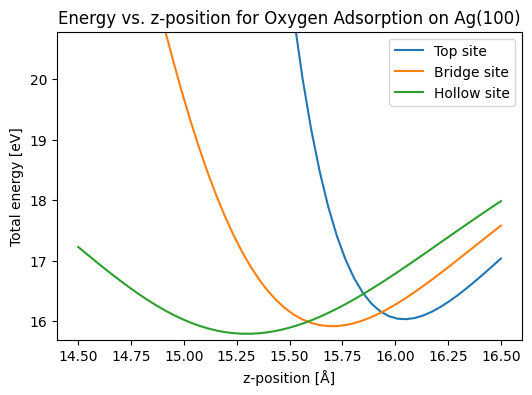

In [12]:
calculator = EMT()
z_positions = np.linspace(14.5, 16.5, 50)
energies_top = evaluate_site(get_top_site, z_positions, calculator)
energies_bridge = evaluate_site(get_bridge_site, z_positions, calculator)
energies_hollow = evaluate_site(get_hollow_site, z_positions, calculator)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(z_positions, energies_top, label='Top site')
ax.plot(z_positions, energies_bridge, label='Bridge site')
ax.plot(z_positions, energies_hollow, label='Hollow site')

ax.set_xlabel('z-position [Å]')
ax.set_ylabel('Total energy [eV]')
ax.set_title('Energy vs. z-position for Oxygen Adsorption on Ag(100)')
ax.legend()

e_min = min(energies_top.min(), energies_bridge.min(), energies_hollow.min())
ax.set_ylim([e_min - 0.1, e_min + 5])

plt.show()

You should find that oxygen binds slightly more strongly to the hollow site. 

However, the potential we used (EMT) is not particularly accurate for this system. 
But doing higher accuracy calculations e.g. requires more computational resources 
than a typical machine has access to. 

However, this is an instance where machine learning can help us! In recent years 
machine-learning based potentials trained on very large databases of high quality 
calculations have become available. One such is SevenNet, which we can try using;

In [13]:
from sevenn.sevennet_calculator import SevenNetCalculator

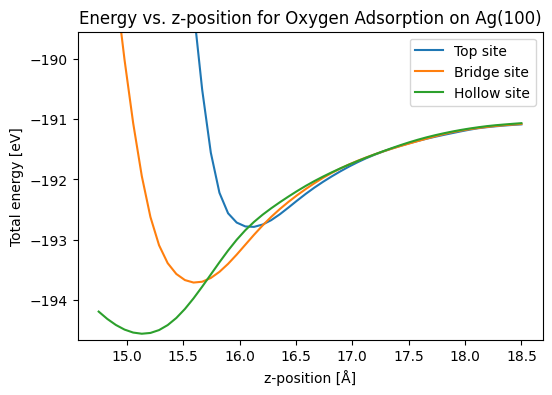

In [14]:

# Only make the calculator once, takes awhile to create each time.
calculator = SevenNetCalculator(model='7net-0', device='cpu')
z_positions = np.linspace(14.75, 18.5, 50)
energies_top = evaluate_site(get_top_site, z_positions, calculator)
energies_bridge = evaluate_site(get_bridge_site, z_positions, calculator)
energies_hollow = evaluate_site(get_hollow_site, z_positions, calculator)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(z_positions, energies_top, label='Top site')
ax.plot(z_positions, energies_bridge, label='Bridge site')
ax.plot(z_positions, energies_hollow, label='Hollow site')

ax.set_xlabel('z-position [Å]')
ax.set_ylabel('Total energy [eV]')
ax.set_title('Energy vs. z-position for Oxygen Adsorption on Ag(100)')
ax.legend()

e_min = min(energies_top.min(), energies_bridge.min(), energies_hollow.min())
ax.set_ylim([e_min - 0.1, e_min + 5])

plt.show()